# Compare $R_{\rm rs}$ for NMF

In [42]:
# imports

from importlib import reload

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
from datetime import datetime, time
import random 
import torch

import pandas
import seaborn as sns

from oceancolor.utils import plotting 
from oceancolor.iop import cross
from oceancolor.hydrolight import loisel23

from ihop import io as ihop_io
from ihop.iops import decompose 
from ihop.emulators import io as emu_io
from ihop.inference import io as inf_io
from ihop.training_sets import load_rs

import reconstruct

In [2]:
%matplotlib ipympl

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load up

In [4]:
hidden_list=[512, 512, 512, 256]
dataset='L23' 
chop_burn=-3000 
abs_sig=None # Noiseless
perc=None
X=4 
Y=0 
#in_idx:int=2663
in_idx:int=0
idx = 170
decomps=('nmf', 'nmf')
Ncomps = (3,2)

In [45]:
ds = loisel23.load_ds(X,Y)

In [5]:
# Load
edict = emu_io.set_emulator_dict(dataset, decomps, Ncomps, 'Rrs',
    'dense', hidden_list=hidden_list, include_chl=True, X=X, Y=Y)

ab, Chl, Rs, d_a, d_bb = ihop_io.load_l23_full(decomps, Ncomps)

emulator, e_file = emu_io.load_emulator_from_dict(edict)

#chain_file = inf_io.l23_chains_filename(edict, abs_sig) 
#d_chains = inf_io.load_chains(chain_file)

Loading... 
Loading decomps from /home/xavier/Projects/Oceanography/python/ihop/ihop/data/NMF/nmf_L23_X4Y0_a_N03.npz and /home/xavier/Projects/Oceanography/python/ihop/ihop/data/NMF/nmf_L23_X4Y0_bb_N02.npz
Loading: /home/xavier/Projects/Oceanography/Color/IHOP/Emulators/L23/L23_X4_Y0_nmfnmf_32_chl_Rrs_dense_512_512_512_256.pth


## Unpack for convenience

In [15]:
H1 = d_a['coeff'][:,0]
H2 = d_a['coeff'][:,1]
H3 = d_a['coeff'][:,2]

In [27]:
wave = d_a['wave']

# Match 

## In $H_1, H_2$

In [18]:
H1_mt = 0.3
H2_mt = 0.1
tol = 0.05
#
in_h1h2 = (np.abs(H1-H1_mt) < H1_mt*tol) &  (np.abs(H2-H2_mt) < H2*tol)
np.sum(in_h1h2)

9

## In $a(440), $H_1$

In [48]:
a440.max()

0.99741

In [106]:
#H1_mt = 0.5
H1_mt, a440_mt = 0.4, 0.02  # with 0.03, 0.1
H1_mt, a440_mt = 0.6, 0.03  # with 0.03, 0.1
i440 = np.argmin(np.abs(wave-440.))
a440 = ds.a.data[:,i440]

tol = 0.05
#
in_ah1 = (np.abs(H1-H1_mt) < H1_mt*tol) &  (np.abs(a440-a440_mt) < a440*tol)
np.sum(in_ah1)
#a440[in_ah1]

34

## Check $H_3$

In [107]:
inin = in_ah1

In [108]:
H3[inin].min(), H3[inin].max(), H3[inin].mean()

(0.027070240739910295, 0.19585002612479005, 0.11600975110865738)

## H3 matches 

In [115]:
#H3_low, H3_high = 0.03, 0.1
H3_low, H3_high = 0.06, 0.16
#
idx_in = np.where(inin)[0]
i_low = idx_in[np.argmin(np.abs(H3[idx_in]-H3_low))]
i_high = idx_in[np.argmin(np.abs(H3[idx_in]-H3_high))]
H1[i_low], H2[i_low], H3[i_low]

(0.5980410541525982, 0.309460034801208, 0.066738621231796)

# Compare

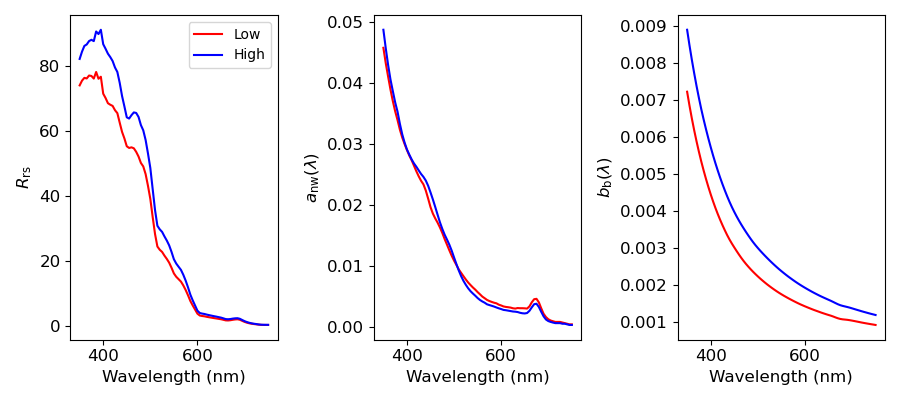

In [116]:
#fig = plt.figure(figsize=(8,4))
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(9,4))

# Rrs
rtio = Rs[i_high]/Rs[i_low]

#ax1.plot(wave, rtio, 'k-', label=f'H3={H3_low:0.2f},{H3_high:0.2f}')
ax1.plot(wave, Rs[i_low], 'r-', label='Low')
ax1.plot(wave, Rs[i_high], 'b-', label='High')
#
ax1.set_ylabel(r'$R_{\rm rs}$')
#
ax1.legend()

# Check a
ax2.plot(wave, ds.anw[i_low], 'r-', label='Low')
ax2.plot(wave, ds.anw[i_high], 'b-', label='High')
ax2.set_ylabel(r'$a_{\rm nw}(\lambda)$')

# Check bb
#ax3.plot(wave, ds.bbnw[i_low], 'g-', label='Low')
#jjax3.plot(wave, ds.bbnw[i_high], color='orange', ls='-', label='High')
ax3.plot(wave, ds.bb[i_low], 'r-', label='Low')
ax3.plot(wave, ds.bb[i_high], color='blue', ls='-', label='High')
ax3.set_ylabel(r'$b_{\rm b}(\lambda)$')

for ax in [ax1, ax2, ax3]:
    plotting.set_fontsize(ax, 12.)
    ax.set_xlabel('Wavelength (nm)')
#
plt.tight_layout()
#
plt.show()

In [96]:
ds

<xarray.Dataset> Size: 18MB
Dimensions:  (Lambda: 81, IOP_Scenario: 3320)
Coordinates:
  * Lambda   (Lambda) float32 324B 350.0 355.0 360.0 365.0 ... 740.0 745.0 750.0
Dimensions without coordinates: IOP_Scenario
Data variables: (12/17)
    Rrs      (IOP_Scenario, Lambda) float32 1MB 0.01176 0.01201 ... 3.041e-05
    Ed_0+    (IOP_Scenario, Lambda) float32 1MB 0.7753 0.7314 ... 1.237 1.222
    Lw       (IOP_Scenario, Lambda) float32 1MB 0.009118 0.008785 ... 3.716e-05
    Lu_0+    (IOP_Scenario, Lambda) float32 1MB 0.04075 0.03903 ... 0.0624
    a        (IOP_Scenario, Lambda) float32 1MB 0.03096 0.02925 ... 2.83 2.85
    anw      (IOP_Scenario, Lambda) float32 1MB 0.02386 0.02245 ... 0.0004
    ...       ...
    bph      (IOP_Scenario, Lambda) float32 1MB 0.04521 0.04454 ... 0.1008
    bd       (IOP_Scenario, Lambda) float32 1MB 0.03323 0.03239 ... 0.03513
    bb       (IOP_Scenario, Lambda) float32 1MB 0.006968 0.006587 ... 0.001876
    bbnw     (IOP_Scenario, Lambda) float32 1MB 0.00105 0.001028 ... 0.001641
    bbph     (IOP_Scenario, Lambda) float32 1MB 0.0004521 0.0004454 ... 0.001008
    bbd      (IOP_Scenario, Lambda) float32 1MB 0.0005982 0.000583 ... 0.0006324